In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import geopandas as gpd
import plotly.express as px
from pynsee.geodata import get_geodata_list, get_geodata

## Visualization of MeteoNet Data

I chose to use MeteoNet dataset for their accesibility and documentation available on their use. The North-West region (NW) of France englobe Loire-Atlantique department and a whole set of data is available : ground wheather stations reports, 2D and 3D weather models... for 2016, 2017, 2018.

The database is quite heavy : 
- NW_ground_stations_2018 = 174 Mo (tar.gz), 1.75 Go (.csv)
- NW_weather_models_2D_2018 = 7.4 Go (tar.gz)

To keep a reasonnable size and ease the process, we focus on base NW_ground_stations_2018 to download [here](https://www.kaggle.com/datasets/katerpillar/meteonet)

In [2]:
raw_df_nw2018 = pd.read_csv(r'./NW2018.csv', sep=',')
raw_df_nw2018.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22034571 entries, 0 to 22034570
Data columns (total 12 columns):
 #   Column      Dtype  
---  ------      -----  
 0   number_sta  int64  
 1   lat         float64
 2   lon         float64
 3   height_sta  float64
 4   date        object 
 5   dd          float64
 6   ff          float64
 7   precip      float64
 8   hu          float64
 9   td          float64
 10  t           float64
 11  psl         float64
dtypes: float64(10), int64(1), object(1)
memory usage: 2.0+ GB


Description de notre set de données : 

- number_sta : ground station number

- lat : latitude into decimal degrees

- lon : longitude into decimal degrees

- height_sta : station height into meters

- date : datetime parameter with the format 'YYY-MM-DD-HH:mm:ss'

- dd : wind direction in degrees

- ff : wind speed in m.s-1

- precip : precipitation during the reporting period in kg.m2

- hu : humidity in %

- td : dew point temperature** in Kelvin

- t : temperature in Kelvin

- psl : pressure reduced to sea level in Pa

** : temperature for which it is needed to refresh an air volume at constant pressure and humidity to become it saturated (i.e. condensation temperature)

In [3]:
raw_df_nw2018.head(-10)

,number_sta,lat,lon,height_sta,date,dd,ff,precip,hu,td,t,psl
0,14066001,49.330,-0.430,2.0,20180101 00:00,240.0,8.2,0.0,84.0,276.75,279.25,NaN
1,14126001,49.150,0.040,125.0,20180101 00:00,NaN,NaN,0.0,98.0,278.75,279.05,NaN
2,14137001,49.180,-0.460,67.0,20180101 00:00,250.0,10.7,0.0,85.0,278.15,280.55,100690.0
3,14216001,48.928,-0.149,155.0,20180101 00:00,240.0,5.4,0.0,77.0,276.45,280.25,NaN
4,14296001,48.790,-1.040,336.0,20180101 00:00,NaN,NaN,0.0,NaN,NaN,278.35,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
22034556,85182004,46.766,-0.831,153.0,20181231 23:54,70.0,3.0,0.0,86.0,278.35,280.55,NaN
22034557,85191003,46.706,-1.382,91.0,20181231 23:54,60.0,3.3,0.0,86.0,278.65,280.85,103640.0
22034558,85215002,46.848,-1.184,62.0,20181231 23:54,NaN,NaN,0.0,NaN,NaN,281.15,NaN
22034559,85216001,46.440,-1.121,3.0,20181231 23:54,60.0,3.5,0.0,NaN,NaN,281.05,NaN


### Simple plot of one parameter : height of each station

In [4]:
def plot_location_height(df_raw, zoom):

    col = ['number_sta', 'lat', 'lon', 'height_sta']

    df_sub_height = df_raw[col]
    df_sub_height = df_sub_height.groupby('number_sta').first()
    df_sub_height = df_sub_height.reset_index()
    df_sub_height.head()

    fig = px.scatter_mapbox(df_sub_height,
                            lat='lat',
                            lon='lon', 
                            hover_name='number_sta',
                            color='height_sta',
                            zoom=zoom,
                            height=400,
                            size_max=15,
                            opacity=0.9,
                            width=800
                            )
    fig.update_layout(mapbox_style='stamen-terrain')
    fig.update_layout(margin={"r": 0, "t": 40, "l": 0, "b": 0})
    fig.update_layout(title_text="Localisation des stations et de leur altitude")
    fig.show()


In [5]:
plot_location_height(raw_df_nw2018, zoom=5)

North-West being too big, we want to focus on Loire-Atlantique zone. To do so, we select the stations within a rectangle given by the 4 extrems of the territory.  

In [6]:
lat_max = 47.835790
lat_min = 46.860601
lon_max = -0.946864
lon_min = -2.558945

df_raw_LA = raw_df_nw2018.loc[(raw_df_nw2018["lat"] > lat_min) & (raw_df_nw2018["lat"] < lat_max) & (raw_df_nw2018["lon"] > lon_min) & (raw_df_nw2018["lon"] < lon_max)]

col = ['number_sta', 'lat', 'lon', 'height_sta']
df_sub_height = df_raw_LA[col]
df_sub_height = df_sub_height.groupby('number_sta').first()
df_sub_height = df_sub_height.reset_index()
df_sub_height.head()

stations_LA = df_sub_height['number_sta'].to_list()
stations_LA.sort()
nb_station = len(stations_LA)
print(f'\nNombre de stations considérées : {nb_station}')
print(stations_LA)


Nombre de stations considérées : 16
[35202001, 35294001, 44020001, 44069002, 44103001, 44110002, 44117002, 44181001, 44184001, 49008001, 49248003, 49276001, 56004001, 56159001, 85097001, 85163001]


# Data recovery from INSEE API

We need some data on our studied territory. The official french statistical agency (INSEE) is given access to its API (Pynsee lib) to get various geographical data on french territory. We found geographical borders of french departments, including Loire-Atlantique. Working with API got the avantage to be integrable into automated process. INSEE gives acces to its geographical data and other indicators (demographic, localisation of corporations...) beeing continuously updated. The documentation is available [here](https://api.insee.fr/catalogue/site/themes/wso2/subthemes/insee/pages/item-info.jag?name=BDM&version=V1&provider=insee) or through pynsee git [here](https://github.com/InseeFrLab/pynsee). 

Collecting the data ask for an authentification to get personal cerdentials (personal_key and personnal_secret below). Once validated, these credentials are locally stored. 

In [7]:
# # subsciption to api.insee
# from pynsee.utils import clear_all_cache; 
# clear_all_cache()

# from pynsee.utils.init_conn import init_conn
# init_conn(insee_key="personal_key", insee_secret="personal_secret")

We are interested in geographical data, so we focus on the "geodata" collection. More specifically we need Loire-Atlantique polygon and 4 other department neighboors.   

We choose which identifier we need (ADMINEXPRESS-COG-CARTO.LATEST:departement), download the data and move it to the right coordinate system (CRS 3857) with geopandas.

In [8]:
get_geodata_list()

Previously saved data has been used:
C:\Users\Utilisateur\AppData\Local/pynsee/pynsee/2ac583be54e866b2b1b30fb0113c1fd0
Set update=True to get the most up-to-date data


,Topic,DataFormat,ApiVersion,Identifier,Abstract,Title,DefaultCRS
0,administratif,WFS,2.0.0,ADMINEXPRESS-COG-CARTO.LATEST:arrondissement,édition 2023,ADMINEXPRESS-COG-CARTO.LATEST:arrondissement.t...,urn:ogc:def:crs:EPSG::4326
1,administratif,WFS,2.0.0,ADMINEXPRESS-COG-CARTO.LATEST:arrondissement_m...,édition 2023,ADMINEXPRESS-COG-CARTO.LATEST:arrondissement_m...,urn:ogc:def:crs:EPSG::4326
2,administratif,WFS,2.0.0,ADMINEXPRESS-COG-CARTO.LATEST:canton,édition 2023,ADMINEXPRESS-COG-CARTO.LATEST:canton.title,urn:ogc:def:crs:EPSG::4326
3,administratif,WFS,2.0.0,ADMINEXPRESS-COG-CARTO.LATEST:chflieu_arrondis...,édition 2023,ADMINEXPRESS-COG-CARTO.LATEST:chflieu_arrondis...,urn:ogc:def:crs:EPSG::4326
4,administratif,WFS,2.0.0,ADMINEXPRESS-COG-CARTO.LATEST:chflieu_commune,édition 2023,ADMINEXPRESS-COG-CARTO.LATEST:chflieu_commune....,urn:ogc:def:crs:EPSG::4326
5,administratif,WFS,2.0.0,ADMINEXPRESS-COG-CARTO.LATEST:chflieu_commune_...,édition 2023,ADMINEXPRESS-COG-CARTO.LATEST:chflieu_commune_...,urn:ogc:def:crs:EPSG::4326
6,administratif,WFS,2.0.0,ADMINEXPRESS-COG-CARTO.LATEST:collectivite_ter...,édition 2023,ADMINEXPRESS-COG-CARTO.LATEST:collectivite_ter...,urn:ogc:def:crs:EPSG::4326
7,administratif,WFS,2.0.0,ADMINEXPRESS-COG-CARTO.LATEST:commune,édition 2023,ADMINEXPRESS-COG-CARTO.LATEST:commune.title,urn:ogc:def:crs:EPSG::4326
8,administratif,WFS,2.0.0,ADMINEXPRESS-COG-CARTO.LATEST:commune_associee...,édition 2023,ADMINEXPRESS-COG-CARTO.LATEST:commune_associee...,urn:ogc:def:crs:EPSG::4326
9,administratif,WFS,2.0.0,ADMINEXPRESS-COG-CARTO.LATEST:departement,édition 2023,ADMINEXPRESS-COG-CARTO.LATEST:departement.title,urn:ogc:def:crs:EPSG::4326


In [9]:
com = get_geodata('ADMINEXPRESS-COG-CARTO.LATEST:departement')
mapcom = gpd.GeoDataFrame(com).set_crs("EPSG:3857")

Previously saved data has been used:
C:\Users\Utilisateur\AppData\Local/pynsee/pynsee/399f6d97ce4631c4e02c487406744440
Set update=True to get the most up-to-date data


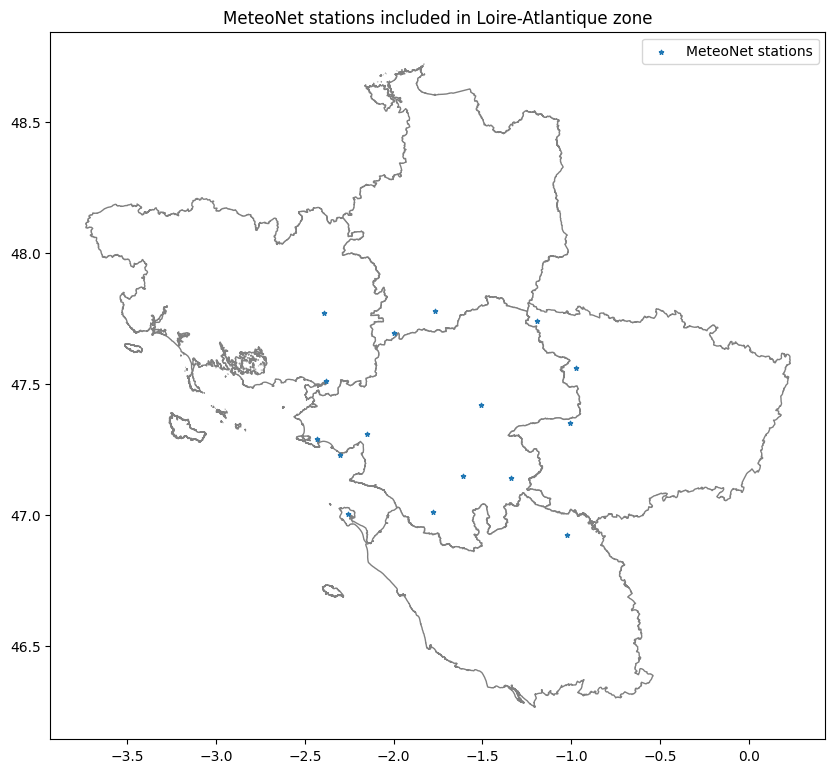

In [20]:
depts = ['ILLE-ET-VILAINE', 'LOIRE-ATLANTIQUE', 'MAINE-ET-LOIRE', 'MORBIHAN', 'VENDEE']
region = mapcom.loc[mapcom['nom_m'].isin(depts)]
region = region.to_crs(epsg=4326) # we move INSEE data to WGS84 as meteo and apdl is in that CRS

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
region.plot(ax=ax, color='white', edgecolor='gray')

# meteo france stations
gdf_meteo_stations = gpd.GeoDataFrame(df_sub_height, geometry=gpd.points_from_xy(df_sub_height.lon, df_sub_height.lat)).set_crs('EPSG:4326')
gdf_meteo_stations.plot(ax=ax, marker='*', markersize=10, label='MeteoNet stations')

ax.set_title('MeteoNet stations included in Loire-Atlantique zone')
plt.legend(loc='upper right')

We could add Air Pays de la Loire stations on the map to put our result in perspective. To do so, we load PM10_horaire_semaine.csv file and only select stations localisation. 

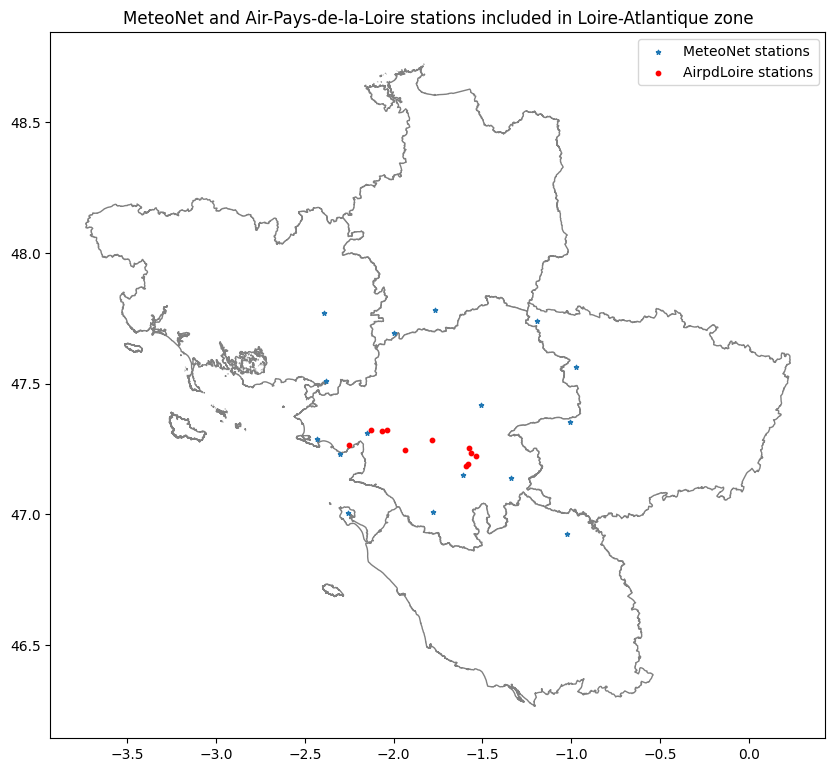

In [19]:
raw_df_PM10_hour_week = pd.read_csv(r'./PM10_horaire_semaine.csv', sep=';')

col_of_interess = ['nom_station', 'x_wgs84', 'y_wgs84']
df_raw_apdl_coord = raw_df_PM10_hour_week[col_of_interess]
df_raw_apdl_coord = df_raw_apdl_coord.rename(columns={'x_wgs84': 'lon', 'y_wgs84': 'lat'})
df_apdl_coord = df_raw_apdl_coord.groupby(['nom_station']).agg({'lon': 'first', 'lat': 'first'})
df_apdl_coord.reset_index(inplace=True)


fig, ax = plt.subplots(1, 1, figsize=(10, 10))
region.plot(ax=ax, color='white', edgecolor='gray')

# meteo france stations
gdf_meteo_stations = gpd.GeoDataFrame(df_sub_height, geometry=gpd.points_from_xy(df_sub_height.lon, df_sub_height.lat)).set_crs('EPSG:4326')
gdf_meteo_stations.plot(ax=ax, marker='*', markersize=10, label='MeteoNet stations')

# Air Pays de la Loire stations
gdf_apdl_stations = gpd.GeoDataFrame(df_apdl_coord, geometry=gpd.points_from_xy(df_apdl_coord.lon, df_apdl_coord.lat)).set_crs('EPSG:4326')
gdf_apdl_stations.plot(ax=ax, marker='o', color='r', markersize=10, label='AirpdLoire stations')

ax.set_title('MeteoNet and Air-Pays-de-la-Loire stations included in Loire-Atlantique zone')
plt.legend(loc='upper right')

### Selection of stations within Loire Atlantique

Air Pays de la Loire stations being localized around Nantes and Saint-Nazaire, we want to focus on stations located along Loire river. We can drop MeteoNet stations at the border of Loire Atlantique, using the id of the station ('number_sta' starting with 44).

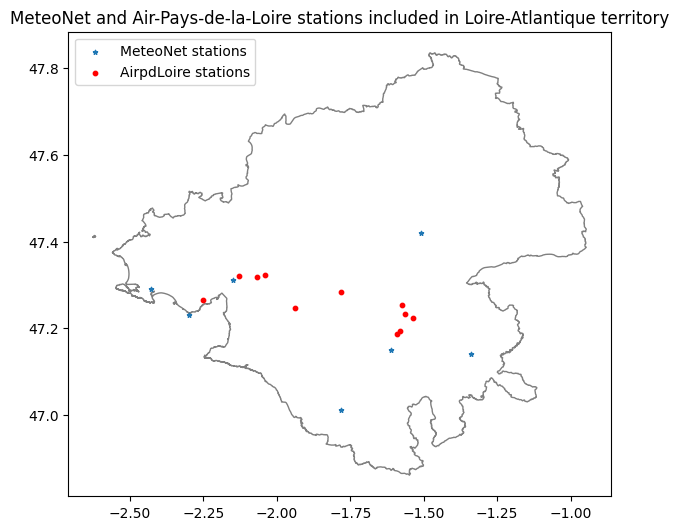

In [22]:
LA = mapcom.loc[mapcom['nom_m'] == 'LOIRE-ATLANTIQUE']
LA = LA.to_crs(epsg=4326)

gdf_meteo_stations_LA = gdf_meteo_stations.loc[(gdf_meteo_stations['number_sta'] >= 44000000) & (gdf_meteo_stations['number_sta'] < 45000000)]

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
LA.plot(ax=ax, color='white', edgecolor='gray')

gdf_meteo_stations_LA.plot(ax=ax, marker='*', markersize=10, label='MeteoNet stations')
gdf_apdl_stations.plot(ax=ax, marker='o', color='r', markersize=10, label='AirpdLoire stations')

ax.set_title('MeteoNet and Air-Pays-de-la-Loire stations included in Loire-Atlantique territory')
plt.legend(loc='upper left')

For info, we could use the sjoin() tool of geopandas to spot the points included in the polygon, but one station is at sea (number_sta = 44184001), therefore not on Loire-continental territory...  

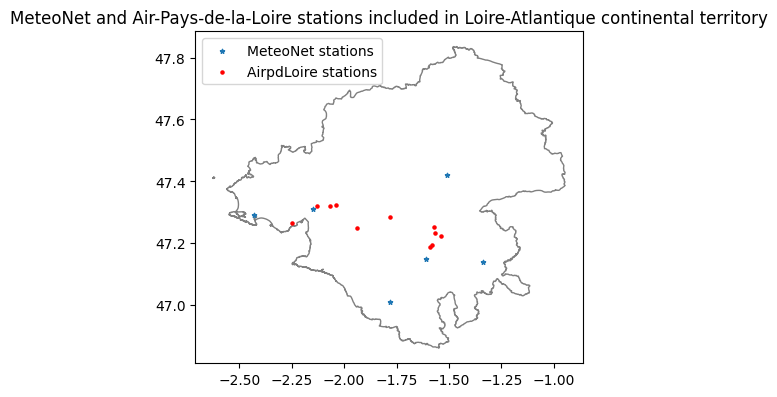

In [23]:
from geopandas.tools import sjoin

pointInPolys = sjoin(gdf_meteo_stations, LA, how='left')
grouped = pointInPolys.groupby('index_right')

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
LA.plot(ax=ax, color='white', edgecolor='gray')

grouped.plot(ax=ax, marker='*', markersize=10, label='MeteoNet stations')
gdf_apdl_stations.plot(ax=ax, marker='o', color='r', markersize=5, label='AirpdLoire stations')

ax.set_title('MeteoNet and Air-Pays-de-la-Loire stations included in Loire-Atlantique continental territory')
plt.legend(loc='upper left')

We now have all the stations of interest. We can dive into what the data can tell us... 

# TODO :

- add height/value parameter 

- start processing meteo data via ML models. But this is maybe for another notebook...